In [4]:
import ResCom as ResCom
import numpy as np
import ReservoirPlot as resplt
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from bayes_opt import BayesianOptimization

## Initial Test:

In [5]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def evolve(RC, ics, t_points):
    ics.append(RC.r_T)
    n = int(round(T/dt))
    traj = []
    
    for r0 in ics:
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj.append(prediction)
    
    return traj 


def plot_traj(traj, t_start=0, t_end=40000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)
    
    
def pred_RMSE(u, u_hat):
    T = max(u_hat.shape[0], u.shape[0])
    square_dist = np.asarray([np.linalg.norm(u_hat[t] - u[t])**2 for t in range(T)])
    return np.sqrt(square_dist.sum()/T)


def score(rho, sigma, t_comp=1000):
    RC.rho = rho
    RC.sigma = sigma
    training_traj = RC.train(train_data, t_points_training, t_listen=100)
    prediction = RC.predict(t_points_prediction)
    return -pred_RMSE(val_data[:t_comp], prediction[:t_comp])

In [6]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

In [7]:
RC = ResCom.ESN(N=100, p=0.01, d=3, rho=0.9, sigma=0.014, gamma=10.0, beta=1e-6)

In [8]:
%%time 
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

CPU times: total: 1 s
Wall time: 1.05 s


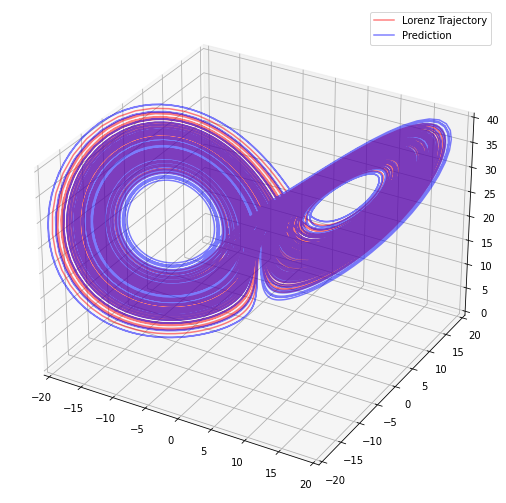

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 20, 20, 40
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.legend()

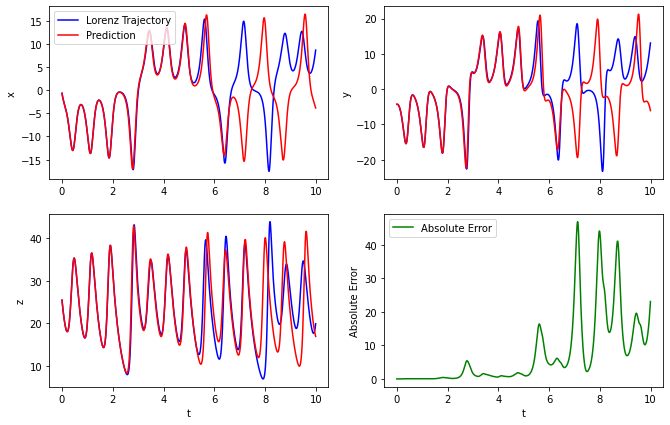

In [10]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1000)

## Optimization:

In [11]:
param_bounds = {'rho': (1e-6, 1.0), 'sigma': (1e-6, 1.0)}

In [12]:
%%time
optimizer = BayesianOptimization(
            f=score,
            pbounds=param_bounds,
            verbose=2,
            random_state=1,
            )

optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   |    rho    |   sigma   |
-------------------------------------------------
| 1         | -20.18    | 0.417     | 0.7203    |
| 2         | -18.58    | 0.0001154 | 0.3023    |
| 3         | -13.82    | 0.1468    | 0.09234   |
| 4         | -15.08    | 0.1863    | 0.3456    |
| 5         | -20.03    | 0.3968    | 0.5388    |
| 6         | -17.75    | 0.4192    | 0.6852    |
| 7         | -52.61    | 0.2045    | 0.8781    |
| 8         | -10.21    | 0.02739   | 0.6705    |
| 9         | -17.9     | 0.4173    | 0.5587    |
| 10        | -15.86    | 0.1404    | 0.1981    |
| 11        | -18.39    | 0.6946    | 0.631     |
| 12        | -16.32    | 0.006241  | 0.5277    |
| 13        | -19.21    | 0.1493    | 0.6288    |
| 14        | -17.56    | 0.3914    | 0.003126  |
| 15        | -10.18    | 0.3956    | 0.1615    |
| 16        | -15.18    | 0.6106    | 0.2253    |
| 17        | -9.751    | 0.9231    | 0.03222   |
| 18        | -15.52    | 1.0       | 0.2303    |


In [13]:
RC.rho = optimizer.max['params']['rho']
RC.sigma = optimizer.max['params']['sigma']
training_traj = RC.train(train_data, t_points_training, t_listen=500)
prediction = RC.predict(t_points_prediction)

In [14]:
xlim = 20
ylim = 20
zlim = 40
t_start = 0
t_end = 15000

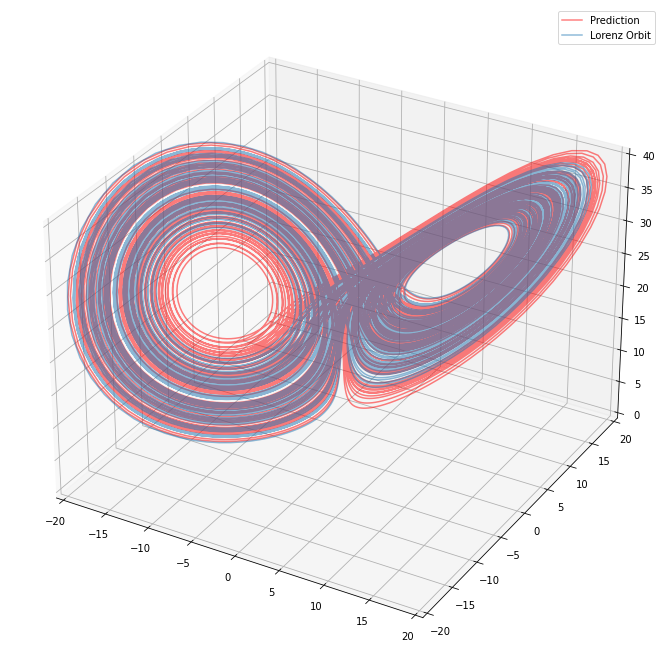

In [15]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(prediction[:,0], prediction[:,1], prediction[:,2],
        'r-',markersize='1.0',alpha=0.5, label='Prediction')

ax.plot(val_data[:,0], val_data[:,1], val_data[:,2], alpha=0.5, label='Lorenz Orbit')
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)
ax.set_zlim(0, zlim)
ax.legend()

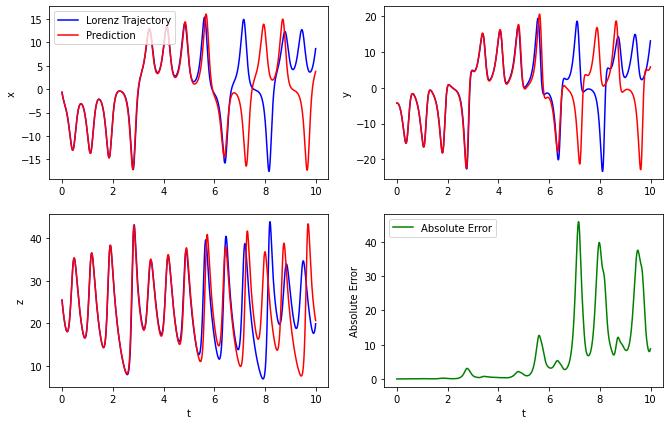

In [16]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1000)